# Working with Raster Data in Python 🌍

This Jupyter Notebook is designed to guide you through the fundamental operations for handling raster data using Python. Raster data, commonly used in remote sensing and environmental modelling, represent continuous spatial phenomena such as land cover, vegetation indices, or elevation.

Throughout this notebook, you will learn how to:
- Read and explore raster files using `rasterio`.
- Extract and visualise spectral bands from satellite imagery.
- Perform basic operations such as histogram analysis and spatial filtering.

The data used here include a Sentinel-2 image, a DEM, and a defined area of interest (AOI). 
This  session is part of the course **“Programación SIG con Python”**, in the **MSc in Geomatics** at the Faculty of Agricultural Sciences, Universidad Nacional de Colombia.

**Lecturer**: Liliana Carolina Castillo Villamor  
**Version**: June 2025  

## 1. Setting the scene
### 1.1. Importing libraries

In [112]:
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations
import scipy.ndimage
import scipy.stats
import rasterio.merge
import rasterio.features


### 1.2. Setting up the data paths


In [24]:
m_root=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres/Datos"
aoi=m_root+r"/aoi.gpkg" # Path to the vector file that contains the AOI
path_s2=m_root+r"/sentinel2_rgb.tif" # Path to the vector file that contains the AOI

## 2. Exploring datasets
### 2.1. Opening the Sentinel-2 image
Open the Sentinel-2 raster using `rasterio.open()` and store it in the variable `s2_rasterio`. This rasterio object provides access to metadata, bands, and other properties of the raster.


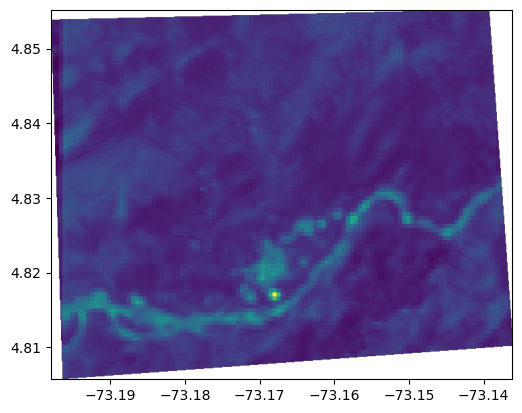

In [120]:
s2_rasterio = rasterio.open(path_s2)
s2_rasterio

# Show the s2_rasterio metadata
s2_rasterio.meta

rasterio.plot.show(s2_rasterio);# Quick view of the Sentinel 2 image 

### ✏️ Now it is your turn!

How many bands does the Sentinel-2 image contain?  
What might each band represent in terms of spectral information (e.g., Red, Green, NIR)?


### 2.2. Listing band descriptions
Loop through all bands in the raster and retrieve their descriptions, which can indicate what type of spectral information each band holds.
We use a **context manager** (`with ... as ...`) to open the raster file. This is a recommended practice when working with file input/output in Python, especially for large raster datasets. Using a context manager ensures that the file is properly closed after the operations are completed, even if an error occurs.


In [124]:
# Open the raster file using a context manager
with rasterio.open(path_s2) as src:
    # Loop through each band in the raster (band indices in rasterio start at 1)
    for i in range(1, src.count + 1):
        # Retrieve the description (name or label) of the current band
        desc = src.descriptions[i - 1]
        # Print the band index along with its description
        print(f"Banda {i}: {desc}")


Banda 1: B1
Banda 2: B2
Banda 3: B3
Banda 4: B4
Banda 5: B5
Banda 6: B6
Banda 7: B7
Banda 8: B8
Banda 9: B8A
Banda 10: B9
Banda 11: B11
Banda 12: B12
Banda 13: AOT
Banda 14: WVP
Banda 15: SCL
Banda 16: TCI_R
Banda 17: TCI_G
Banda 18: TCI_B
Banda 19: MSK_CLDPRB
Banda 20: MSK_SNWPRB
Banda 21: QA10
Banda 22: QA20
Banda 23: QA60
Banda 24: MSK_CLASSI_OPAQUE
Banda 25: MSK_CLASSI_CIRRUS
Banda 26: MSK_CLASSI_SNOW_ICE


### 2.3. Visualising Band Histograms

As part of the exploratory data analysis, you will examine the distribution of pixel values in each band using histograms to identify:

- The range and frequency of pixel intensities.
- Whether a band contains many zero or missing (NoData) values.
- Potential outliers or saturation effects in the imagery.


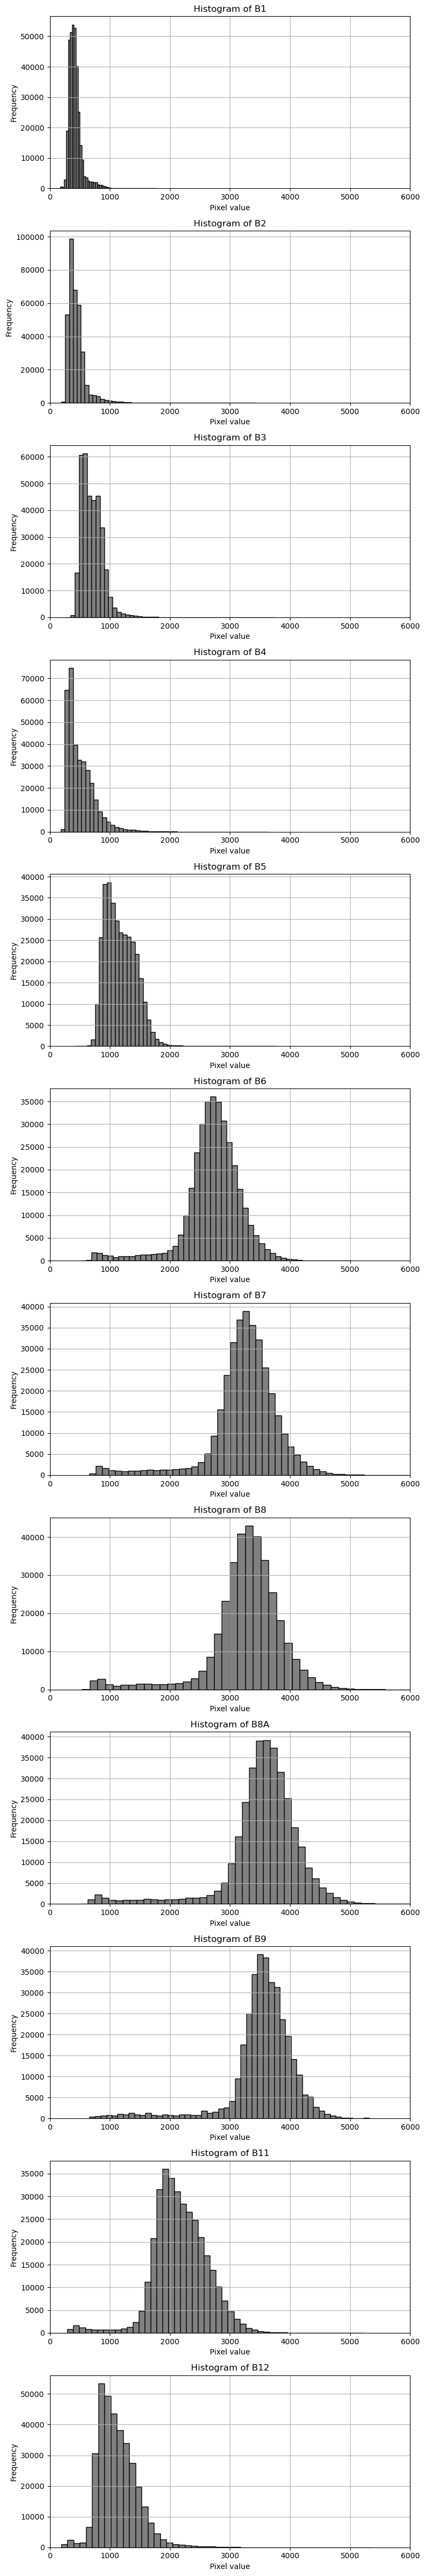

In [134]:
# Open the Sentinel-2 image using a context manager, which ensures the file is properly closed afterwards.
# Retrieve the total number of bands and limit it to a maximum of 12 (based on the previous output)
# Each band is read into memory as a NumPy array, and it is also retrieved the labels of each band.

with rasterio.open(path_s2) as src:
    total_bandas = src.count
    max_bandas = min(12, total_bandas)  # Asegura que no se pase si hay menos de 13 bandas
    bandas = [src.read(i + 1) for i in range(max_bandas)]
    nombres_bandas = src.descriptions[:max_bandas]  # Solo hasta la banda 13

# Create a matplotlib figure with subplots to prepare a subplot for each band to plot its histogram separately.
# The figure height is adjusted dynamically based on the number of bands.

fig, axs = plt.subplots(nrows=max_bandas, figsize=(8, 4 * max_bandas))


# We loop over the list of bands to Plot histograms for each band

for i, banda in enumerate(bandas):
    banda = banda[np.isfinite(banda)] # - Remove any non-finite values (NaNs or infinities), which may result from masked areas.
    banda = banda[banda != 0]  # - Optionally filter out zero values, which in some datasets represent NoData.
    
    # Ensure that each band has a readable label for plotting. 
    #If the raster metadata contains a name for the band, we use it. Otherwise, ti uses generic label like 'Banda 1', 'Banda 2', and so on. 
    #This prevents issues when band names are missing or empty.
    nombre_banda = nombres_bandas[i] if nombres_bandas[i] else f"Banda {i + 1}" # - Retrieve a readable band name (fallback to "Band X" if no description is available).

    # - Plot the histogram using 50 bins, setting limits and labels to make plots readable and consistent.
    axs[i].hist(banda.flatten(), bins=50, color='grey', edgecolor='black')
    axs[i].set_title(f'Histogram of {nombre_banda}')
    axs[i].set_xlabel('Pixel value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(0, 6000)   # Fix x-axis range for consistency across plots
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### 2.4.  Alternative visualisation: all histograms in a single multi-panel figure

Instead of displaying each histogram in a separate output cell, you can also present **all histograms together in a single plot using subplots**. This approach is especially helpful when you want to visually compare bands side-by-side or export all graphics as one image.

Below is an example using a grid of subplots to show the pixel value distribution of each band.


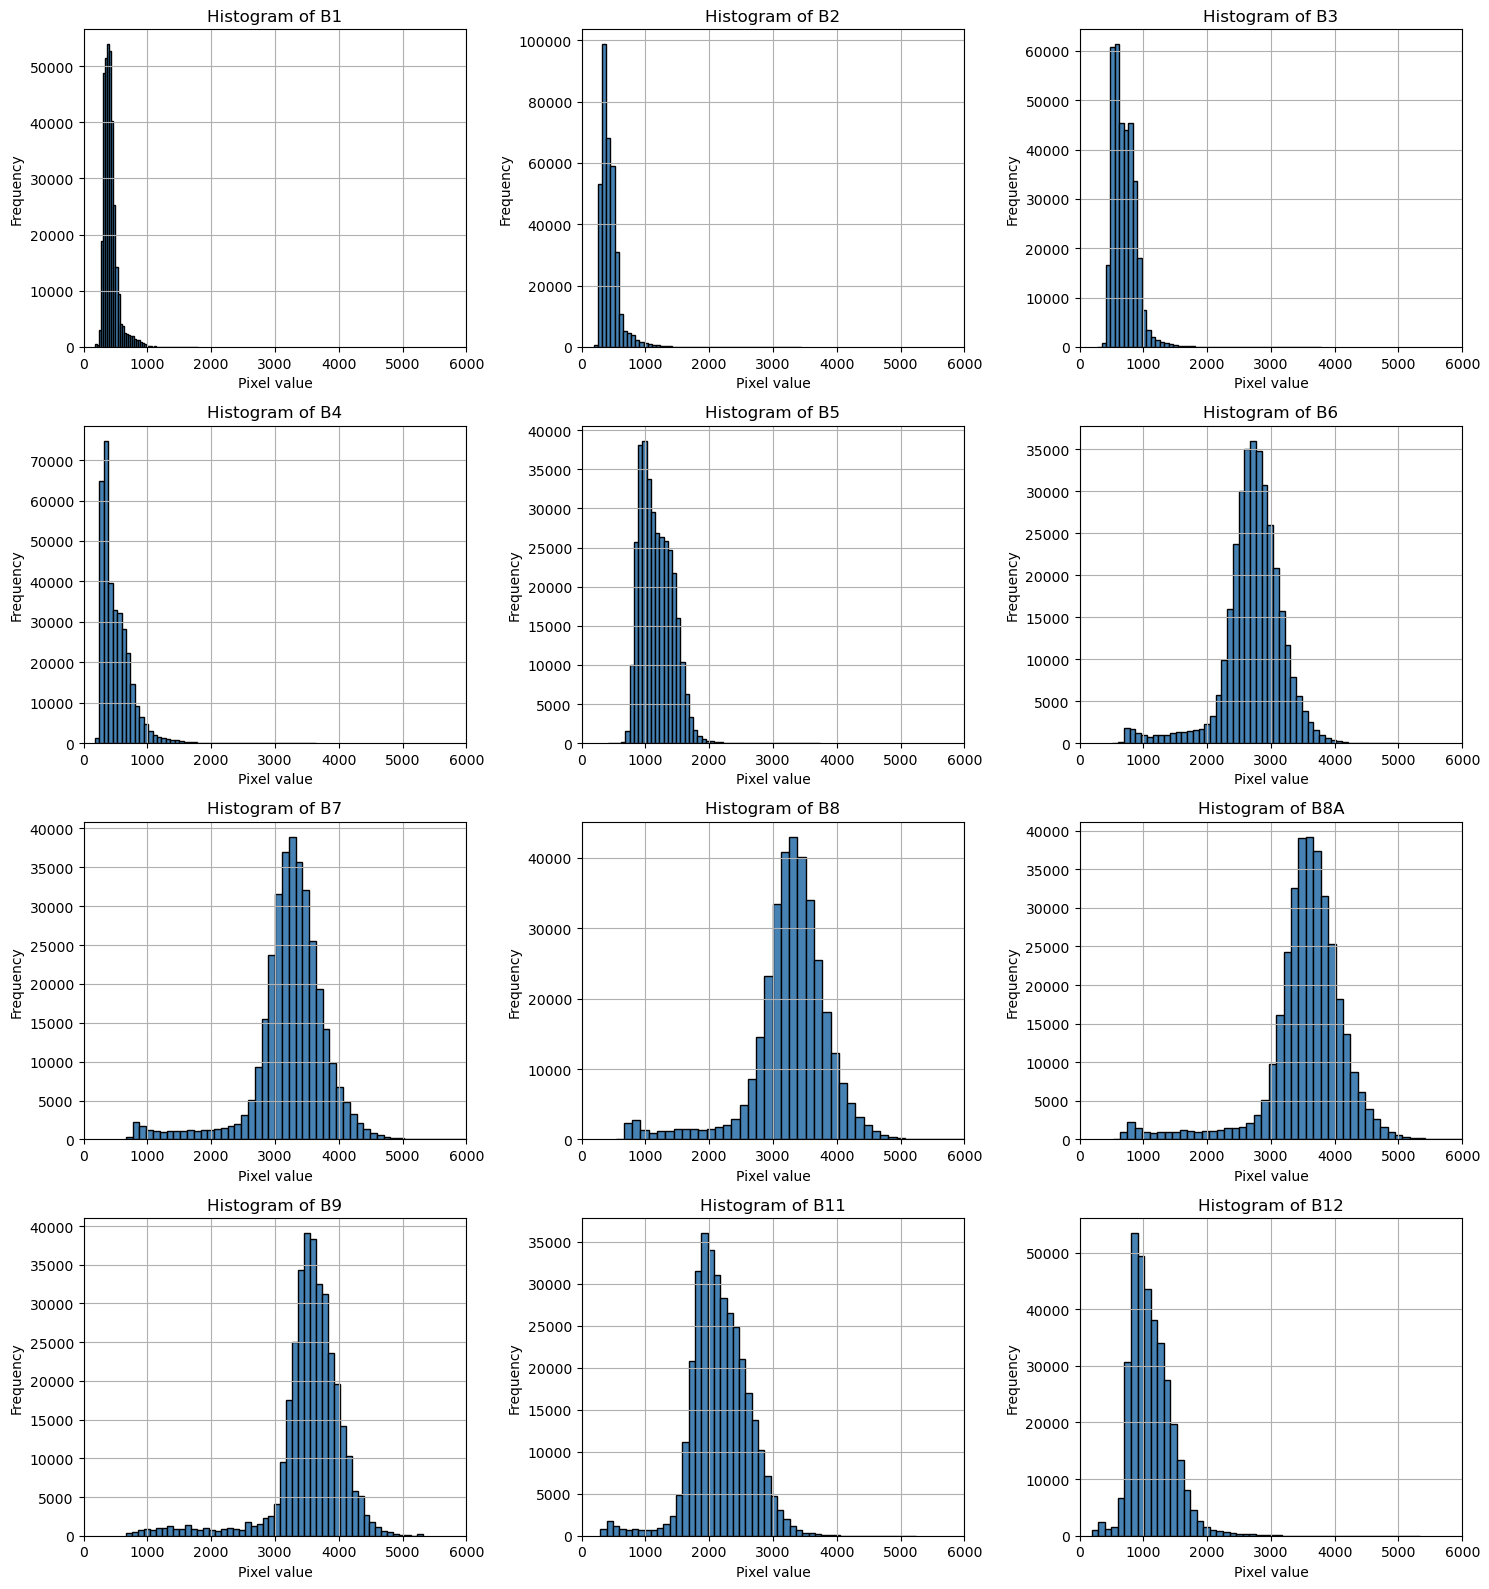

In [144]:
import math

# Define number of rows and columns for the grid layout
n_rows = math.ceil(max_bandas / 3)
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten axs array for easy indexing
axs = axs.flat

# Loop through each band and plot its histogram
for i, banda in enumerate(bandas):
    banda = banda[np.isfinite(banda)]
    banda = banda[banda != 0]

    nombre_banda = nombres_bandas[i] if nombres_bandas[i] else f"Banda {i + 1}"

    axs[i].hist(banda.flatten(), bins=50, color='steelblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {nombre_banda}')
    axs[i].set_xlabel('Pixel value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(0, 6000)
    axs[i].grid(True)

# Hide any extra subplots (if bands < total grid cells)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### 2.5. Estimating the pixel value distribution using kernel density estimation (KDE)

Instead of using traditional histograms,  use **Kernel Density Estimation (KDE)** to estimate the probability density function of pixel values in each band.

The function `gaussian_kde` from the `scipy.stats` module fits a smooth curve to the distribution of values. Unlike histograms, KDE curves do not depend on bin size and can provide a clearer view of underlying patterns, especially when comparing multiple bands on the same plot.

In this script, each band's KDE is plotted on the same figure using different colours and labels.
> Note: KDE requires a sufficient number of valid values. If a band contains too few pixels, it is skipped to avoid errors.


<function matplotlib.pyplot.show(close=None, block=None)>

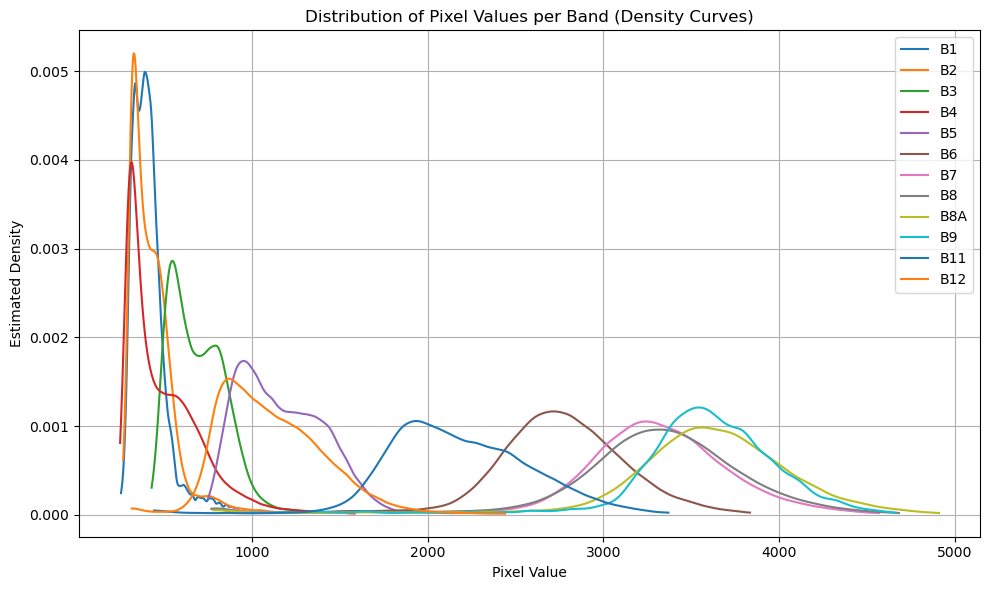

In [154]:
from scipy.stats import gaussian_kde
# Open the raster file
with rasterio.open(path_s2) as src:
    max_bands = min(12, src.count)  # Limit to 12 bands, 
    bands = [src.read(i + 1) for i in range(max_bands)]  # Read each band (1-indexed)
    band_names = src.descriptions[:max_bands]  # Retrieve band names from metadata

# Create a single figure for the density plots
plt.figure(figsize=(10, 6))

# Loop through each band and compute its density
for i, band in enumerate(bands):
    # Remove invalid values (e.g. NaN, Inf) and zeros if considered NoData
    band = band[np.isfinite(band)]
    band = band[band != 0]

    # Ensure there are enough valid values to compute density
    if band.size < 2:
        print(f" Band {i + 1} has fewer than 2 valid values. Skipping.")
        continue

    try:
        # Perform kernel density estimation (KDE) for the band
        kde = gaussian_kde(band.flatten())
        x_vals = np.linspace(np.percentile(band, 0.5), np.percentile(band, 99.5), 500)
        y_vals = kde(x_vals)

        # Use the band name from metadata, or fallback to generic name
        band_label = band_names[i] if band_names[i] else f"Band {i + 1}"

        # Plot the density curve
        plt.plot(x_vals, y_vals, label=band_label)

    except Exception as e:
        print(f" Error processing Band {i + 1}: {e}")

# Customise the final plot
plt.title('Distribution of Pixel Values per Band (Density Curves)')
plt.xlabel('Pixel Value')
plt.ylabel('Estimated Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show


## 3. Spatial Subsetting

Spatial subsetting refers to the process of selecting and retrieving raster values based on spatial criteria, such as point coordinates or masks. Rather than indexing by rows and columns, we can use geographic coordinates or boolean arrays to filter data spatially.

There are two main approaches:

1. **Point-based subsetting**, where values are sampled at specific coordinates.
2. **Mask-based subsetting**, where raster values are filtered using another raster (or logical conditions) to mask out unwanted pixels.

This section will demonstrate both techniques using Rasterio and NumPy.


### 3.1. Sampling raster values at specific locations

Rasterio provides a `.sample()` method that allows us to extract the value of a raster cell covering a given coordinate. The input must be a list of `(x, y)` tuples in the raster’s coordinate reference system.

The `.sample()` method returns a *generator*, which is an efficient way of producing values one at a time (rather than storing all results in memory at once).


Before sampling raster values at specific locations, it is important to understand the spatial extent and coordinate reference system (CRS) of the image. First, we we open the raster using a context manager and retrieve two key pieces of information.  `src.bounds` provides the **spatial extent** (bounding box) of the raster in map coordinates. It includes the minimum and maximum values of X and Y (i.e. west, south, east, north).

Knowing the bounds helps you can select appropriate (x, y) coordinates for sampling — they must fall within this extent to return valid values.


In [159]:
with rasterio.open(path_s2) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)


CRS: EPSG:4326
Bounds: BoundingBox(left=-73.19796328508144, bottom=4.805717275454204, right=-73.13615919353401, top=4.85521444760919)


The `.sample()` method in `rasterio` allows you to extract pixel values from a raster at specific geographic locations. The input must be a list of coordinate tuples `(x, y)` in the raster’s CRS (as verified previously using `src.crs`).
The following script opens the Sentinel-2 raster. Then, a single coordinate is passed to `.sample()` to retrieve the pixel value at that point. The method returns a generator, a special type of iterable that produces values on the fly, one at a time, only when requested. Unlike lists, which store all elements in memory, generators are more memory-efficient, especially when dealing with large datasets such as raster grids. 
>Imagine a juice machine (generator):
>You press the button, and it makes one cup of juice when you need it.
>Now compare that to a fridge full of bottles (list):
>All the juice is already prepared and takes up space, even if you don’t drink it all.


The generator is converted into a list to retrieve the pixel values for all provided locations.

Each result is a NumPy array containing the value(s) for the raster band(s) at that point.

>  Note: If the raster has multiple bands, the array will contain one value per band. Asli, coordinates must fall within the raster bounds; otherwise, the result may be empty or cause an error.

In [163]:

with rasterio.open(path_s2) as src_s2:
    # Sample a single point
    gen = src_s2.sample([(-73.18,4.831)])
    print(next(gen))  # Output: array([16], dtype=uint8)

    # Sample multiple points at once
    coords = [(-73.180, 4.820), (-73.150, 4.850)]
    values = list(src_s2.sample(coords))
    print(values)  # Output: [array([16], dtype=uint8), array([6], dtype=uint8)]


[ 379.5  452.   743.   491.  1135.  2856.  3466.  3401.  3720.  3527.5
 2248.  1156.5  146.5 2550.     4.    50.    76.    46.     0.     0.
    0.     0.     0.     nan    nan    nan]
[array([ 408.5,  824.5, 1288.5, 1717. , 2044.5, 2538.5, 2724. , 2606. ,
       2890.5, 2712. , 3103. , 2034. ,  148. , 2513. ,    5. ,  174. ,
        131. ,   85. ,    0. ,    0. ,    0. ,    0. ,    0. ,    nan,
          nan,    nan]), array([ 356.5,  336.5,  545. ,  317. ,  861. , 2503. , 3139. , 3252.5,
       3470.5, 3458. , 1811.5,  819. ,  140.5, 2460. ,    4. ,   33. ,
         56. ,   33.5,    0. ,    0. ,    0. ,    0. ,    0. ,    nan,
          nan,    nan])]


### 3.2.  Visualising raster data with sample points

In this example, we use `matplotlib`, `rasterio`, and `geopandas` to visualise a raster image and overlay point locations on top of it.




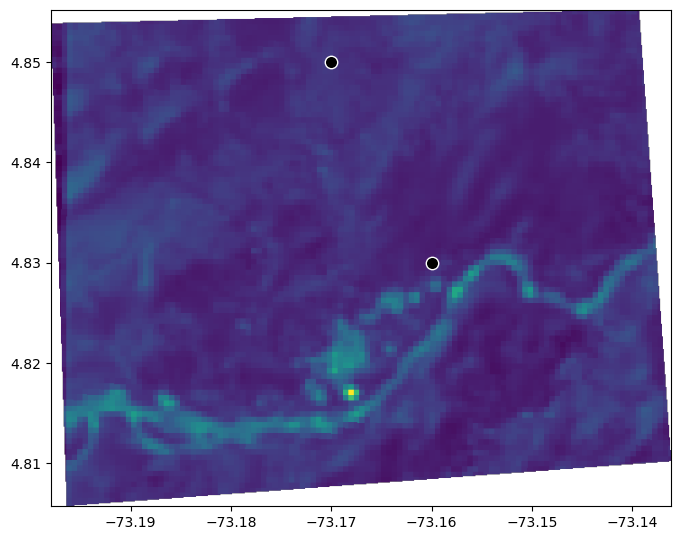

In [180]:
from shapely.geometry import Point # To create point geometries defined by (x, y) coordinates. 
                                    # Useful when sampling raster values at specific locations 
                                    # or plotting geographic features like observation points.

# Define points inside the raster extent
points = [
    Point(-73.17, 4.85),
    Point(-73.16, 4.83)
]

# Create GeoSeries for plotting
points_gs = gpd.GeoSeries(points)

# Open and plot raster with points on top
with rasterio.open(path_s2) as src_s2:
    fig, ax = plt.subplots(figsize=(8, 8))
    rasterio.plot.show(src_s2, ax=ax)
    points_gs.plot(ax=ax, color='black', edgecolor='white', markersize=80)


### 3.3. Boolean masking with NumPy

Another form of spatial subsetting uses boolean arrays as masks. A *mask* is a 2D array of `True` or `False` values that define which pixels to retain or ignore.

n the following cell we simulate missing or invalid data by creating a random boolean mask and applying it to a raster band. This is useful for testing how algorithms or visualisations handle incomplete data.

In [21]:
# Open the raster file and read the first band as a NumPy array
with rasterio.open(path_s2) as src_s2:
    band1 = src_s2.read(1)  # Read band 1 (indexing starts at 1 in rasterio)

# Set a random seed for reproducibility
np.random.seed(1)

# Create a random boolean mask with the same shape as the raster band
# Each pixel is randomly assigned either True or False
mask = np.random.choice([True, False], band1.shape)

# Create a masked version of band1
masked_b1 = band1.copy().astype('float64')  # Convert to float to allow np.nan values
masked_b1[mask] = np.nan  # Assign NaN to all positions where the mask is True

# Display the masked raster array
print(masked_b1)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


 Masking with a condition

In [23]:
# Mask all values below 20
band1_masked = band1.copy().astype('float64')
band1_masked[band1_masked>500] = np.nan
print(band1_masked)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


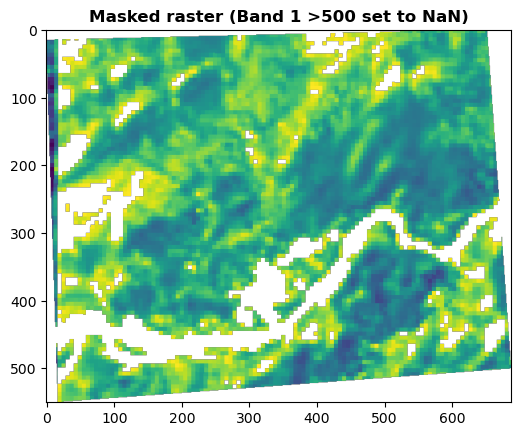

In [24]:
import rasterio.plot

plt.figure(figsize=(6, 6))
rasterio.plot.show(band1_masked, cmap='viridis', title='Masked raster (Band 1 >500 set to NaN)')
plt.show()

### ✏️  Now it’s your turn

1. Load the raster `elev.tif` and extract values at other coordinates:


2. Create a mask that removes (i.e., sets to NaN) all values **smaller than 2500** from band 8 (NIR) 

3. Plot the masked raster using `rasterio.plot.show()` and describe the areas that were masked.




## 3.3.2 Map Algebra

Map algebra refers to operations applied on raster data to compute new outputs based on cell values.
These operations are often classified as:

 - **Local** (per-cell): applied independently to each pixel
 - **Focal**: based on neighbourhoods of cells
 - **Zonal**: uses zones of similar values
 - **Global**: uses entire raster statistics

 In this notebook, we focus on **local operations**, which are most relevant for pixel-wise analysis using NumPy.

### Local operations: arithmetic and logic
We start by applying local operations to a Sentinel-2 band loaded from GEE. These include arithmetic transformations,
logical comparisons, and raster reclassification.


In [27]:

with rasterio.open(path_s2) as src:
    band_red = src.read(4).astype('float32')

# 1. Add the band to itself
band_sum = band_red + band_red

# 2. Square the values
band_squared = band_red**2

# 3. Convert to int64 and square to avoid overflow
band_squared_safe = band_red.astype('float64') ** 2

# 4. Apply log transformation (add small value to avoid log(0))
band_log = np.log1p(band_red)

# 5. Apply logical condition (values > 1000)
band_mask = band_red > 1000


 ### Visualising local operations

The following figures demonstrate various local raster operations:
 - Red + Red
- Red squared
 - Log-transformed Red
- Pixels with values > 1000

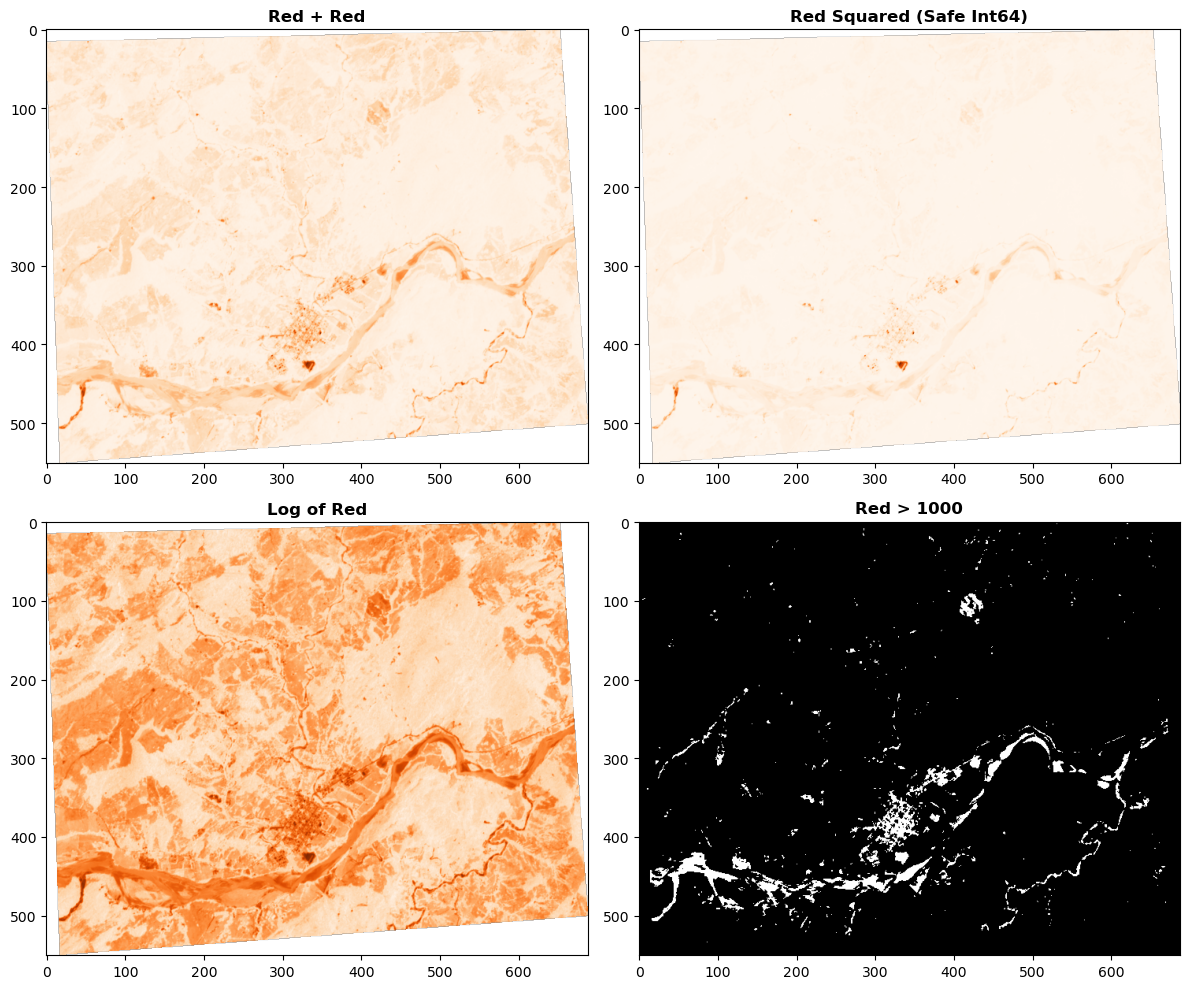

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
rasterio.plot.show(band_sum, ax=axs[0, 0], cmap='Oranges', title='Red + Red')
rasterio.plot.show(band_squared_safe, ax=axs[0, 1], cmap='Oranges', title='Red Squared (Safe Int64)')
rasterio.plot.show(band_log, ax=axs[1, 0], cmap='Oranges', title='Log of Red')
rasterio.plot.show(band_mask.astype('uint8'), ax=axs[1, 1], cmap='gray', title='Red > 1000')
plt.tight_layout()
plt.show()


### Calculating vegetation indices using local operations

Just as we previously applied local arithmetic and logical operations on individual bands, we can use the same principles to compute spectral indices such as the Normalised Difference Vegetation Index (NDVI). 

NDVI is a widely used indicator of vegetation health and density. It is calculated using the near-infrared (NIR) and red bands, based on the following formula:

\\[
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}
\\]

Positive values (typically above 0.2) suggest the presence of green vegetation, whereas values near or below zero may indicate bare soil, water, or built-up areas.

Below, we calculate NDVI using Sentinel-2 bands 8 (NIR) and 4 (Red), following the same logic as in previous local operations.



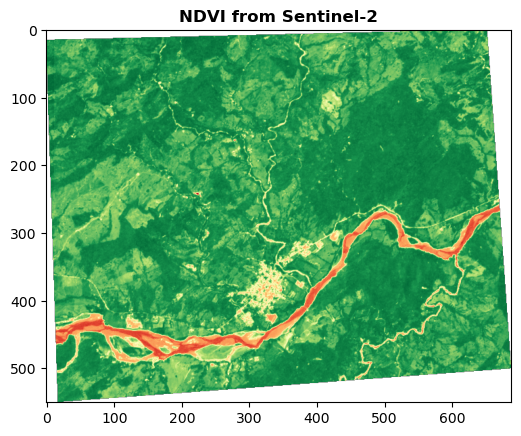

In [43]:

with rasterio.open(path_s2) as src:
    red = src.read(4).astype('float32')
    nir = src.read(8).astype('float32')
    ndvi = (nir - red) / (nir + red + 1e-6)  # add small value to avoid division by 0

# Clip NDVI values to [-1, 1] range (optional visual clean-up)
ndvi = np.clip(ndvi, -1, 1)

# Plot NDVI
plt.figure(figsize=(6, 6))
rasterio.plot.show(ndvi, cmap='RdYlGn', title='NDVI from Sentinel-2')
plt.show()

## 🧩 Now it’s your turn

Using the same approach as with NDVI, calculate other spectral indices from the Sentinel-2 image. You may refer to the following formulas and suggested combinations:

1. **GNDVI (Green Normalised Difference Vegetation Index)**  
   \[
   \text{GNDVI} = \frac{\text{NIR} - \text{Green}}{\text{NIR} + \text{Green}}
   \]  
   - Use **Band 8 (NIR)** and **Band 3 (Green)**

2. **NDWI (Normalised Difference Water Index)**  
   \[
   \text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}
   \]  
   - Also uses **Band 8 (NIR)** and **Band 3 (Green)**

3. (Optional – advanced) **NDMI (Normalised Difference Moisture Index)**  
   \[
   \text{NDMI} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}
   \]  
   - Use **Band 8 (NIR)** and **Band 11 (SWIR1)**


- Choose all  the indices above.
- Calculate the indices following the same logic as for NDVI.
- Visualise your result using an appropriate colour map.

> 💡 *Hint:* Use `.astype('float32')` before computing ratios, and apply a small constant (e.g., `1e-6`) in the denominator to avoid division by zero.


### Reclassification

We can reclassify a continuous raster into categories. For example, we define three elevation classes:
- Low (class 1): values 0–2000
- Medium (class 2): 2000–5000
- High (class 3): >5000


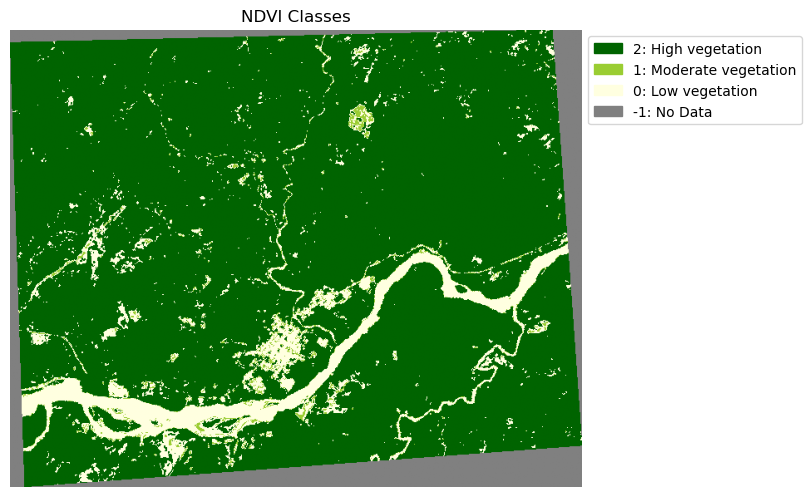

In [47]:
# Make a copy of the NDVI array to preserve the original
ndvi_class = ndvi.copy()

# Create custom colormap with fixed colours
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Apply reclassification based on NDVI thresholds
ndvi_class[(ndvi < 0.1)] = 0    # Class 0: No or very low vegetation
ndvi_class[(ndvi >= 0.4) & (ndvi <= 0.5)] = 1  # Class 1: Moderate vegetation
ndvi_class[(ndvi > 0.6)] = 2    # Class 2: Dense and healthy vegetation


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import ListedColormap

# Clean NDVI classification by replacing NaNs with a sentinel value (-1)
ndvi_class_clean = np.where(np.isnan(ndvi_class), -1, ndvi_class).astype('int32')

# Shift values by +1 so that: -1 → 0 (nodata), 0 → 1, 1 → 2, 2 → 3
ndvi_plot_data = ndvi_class_clean + 1

# Define colours: [NoData, Low, Moderate, High]
colours = ['grey', 'lightyellow', 'yellowgreen', 'darkgreen']
custom_cmap = ListedColormap(colours)

# Create legend patches
legend_patches = [
    mpatches.Patch(color='darkgreen', label='2: High vegetation'),
    mpatches.Patch(color='yellowgreen', label='1: Moderate vegetation'),
    mpatches.Patch(color='lightyellow', label='0: Low vegetation'),
    mpatches.Patch(color='grey', label='-1: No Data')
]

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_plot_data, cmap=custom_cmap)
plt.title("NDVI Classes")
plt.axis("off")
plt.legend(handles=legend_patches, bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 3.3.4 Focal Operations

Focal operations—also known as *spatial filtering* or *convolution*—compute each raster cell value using not only the value of that cell, but also the values of its neighbours.

They use a **moving window** (e.g., 3×3) centred on each cell. For each position of the window, a function (such as `mean`, `min`, `max`, or `mode`) is applied to the values within the window. The result is then assigned to the central cell in the output raster.

This type of operation is essential in image processing, terrain analysis, and noise reduction.

In this group of functions, we define the shape of the moving window in one of two ways:

- `size` — a single number (e.g., `3`) or a tuple (e.g., `(3, 3)`) defining the width and height of the rectangular window;
- `footprint` — a boolean array indicating both the shape of the window and which elements to include in the calculation (useful for custom or circular neighbourhoods).

In addition to specific built-in filters such as `minimum_filter`, `maximum_filter`, or `uniform_filter`, the following functions offer greater flexibility:

- `convolve` — applies a custom **weighted** filter (e.g., Sobel, Laplacian) by multiplying the neighbourhood


### 🧠 Example: Understanding a 3×3 Neighbourhood

Suppose we have a 4×4 elevation raster:

|     |     |     |     |
|-----|-----|-----|-----|
|  3  |  4  |  2  |  1  |
|  5  | 12  |  6  |  8  |
|  7  | 14  |  9  |  3  |
|  2  | 10  | 11  |  5  |

Now, apply a **3×3 mean filter** centred on the cell with value `12` (second row, second column). The 3×3 window will include:

|     |     |     |
|-----|-----|-----|
|  3  |  4  |  2  |
|  5  | 12  |  6  |
|  7  | 14  |  9  |

The mean of this window is:
(3 + 4 + 2 + 5 + 12 + 6 + 7 + 14 + 9) / 9 = 7.56


So in the **output raster**, the central cell will be replaced by **`7.56`**, or **`8`**, in case that you work only with ineger values




#### Edge Consideration

For a corner cell (e.g., top-left), the 3×3 window is incomplete. You can:

- **Extend** the raster with a padding method (e.g., `'reflect'`, `'nearest'`, or `'constant'`)
- Or **ignore** those cells in the result (assign `NaN`) to ensure all windows are complete

This strategy helps control the influence of edge pixels in your analysis.
Sometimes artificially extending raster edges is considered unsuitable. In other words, we may wish the resulting raster to contain pixel values with ‘complete’ windows only, for example, to have a uniform sample size or because values in all directions matter (such as in topographic calculations).


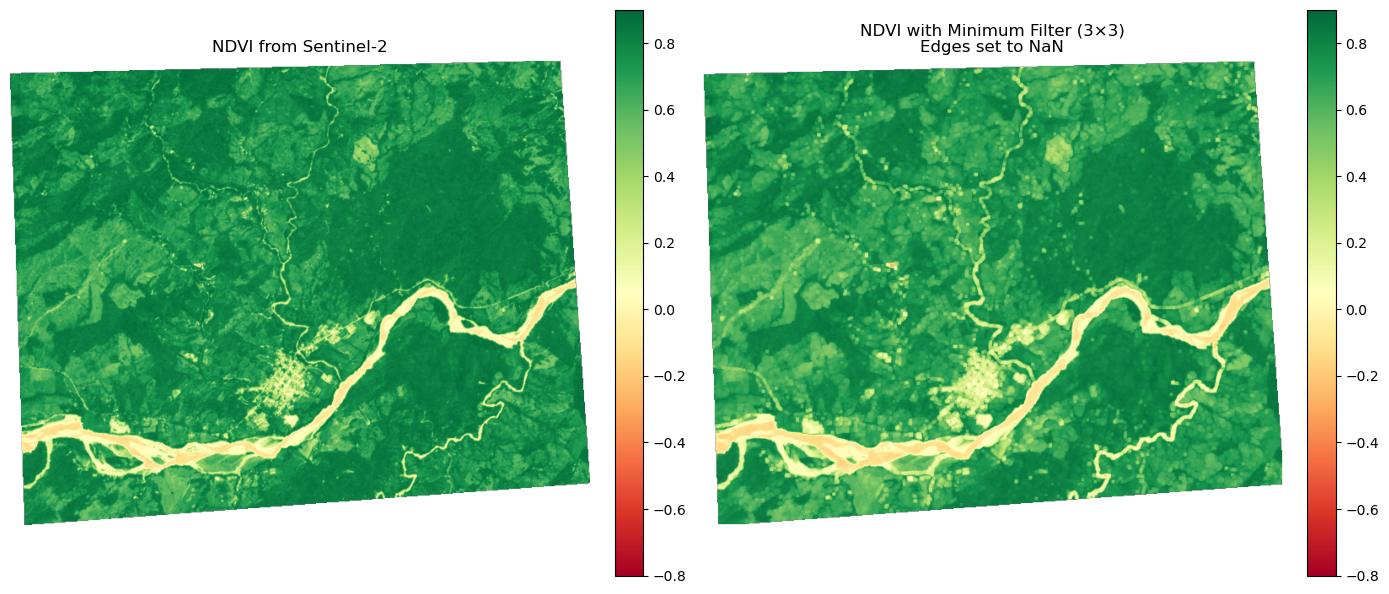

In [102]:
from scipy import ndimage # Provides image processing functions such as filters for applying focal operations on arrays

# Apply 3x3 minimum filter to the NDVI
ndvi_min = ndimage.minimum_filter(ndvi, size=3)

# Convert to float to allow NaN assignment
ndvi_min = ndvi_min.astype(float)

# Assign NaN to the borders (one pixel thick) to indicate incomplete neighbourhoods
ndvi_min[:, [0, -1]] = np.nan  # First and last columns
ndvi_min[[0, -1], :] = np.nan  # First and last rows

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: Original NDVI
ndvi_plot = axs[0].imshow(ndvi, cmap='RdYlGn', vmin=-0.8, vmax=0.9)
axs[0].set_title("NDVI from Sentinel-2")
axs[0].axis("off")
fig.colorbar(ndvi_plot, ax=axs[0], fraction=0.046, pad=0.04)

# Right: Minimum-filtered NDVI with NaN borders
ndvi_min_plot = axs[1].imshow(ndvi_min, cmap='RdYlGn', vmin=-0.8, vmax=0.9)
axs[1].set_title("NDVI with Minimum Filter (3×3)\nEdges set to NaN")
axs[1].axis("off")
fig.colorbar(ndvi_min_plot, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [62]:
grain_mode = scipy.ndimage.generic_filter(
    ndvi_class_clean, 
    lambda x: scipy.stats.mode(x.flatten(), keepdims=True)[0], 
    size=3
)

grain_mode = grain_mode.astype(float)  # Convert to float to allow NaN assignment
grain_mode[:, [0, -1]] = np.nan
grain_mode[[0, -1], :] = np.nan

grain_mode

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, -1., -1., ..., -1., -1., nan],
       [nan, -1., -1., ..., -1., -1., nan],
       ...,
       [nan, -1., -1., ..., -1., -1., nan],
       [nan, -1., -1., ..., -1., -1., nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [84]:
ndvi_min = scipy.ndimage.minimum_filter(ndvi, size=3)
ndvi_min


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

###  Visual comparison of original and filtered NDVI classification (zoomed view)

Visualise and compare two versions of the NDVI classification image:

- On the **left**, we display a zoomed-in portion of the original NDVI classification (`ndvi_class_clean`) to focus on a smaller area and better observe the spatial distribution of vegetation classes.
- On the **right**, we show the same area after applying a **mode filter** using a 3×3 neighbourhood (`grain_mode`). This filter smooths the classification by replacing each cell with the most common value in its surrounding window — a common technique in image processing to reduce noise.

We also include a **custom legend** to interpret each class:
- `0`: Low vegetation
- `1`: Moderate vegetation
- `2`: High vegetation
- `NaN`: No data or invalid pixels

This side-by-side comparison helps to understand the effect of local focal operations (in this case, the mode filter) and illustrates how they can improve the coherence of classified raster data.


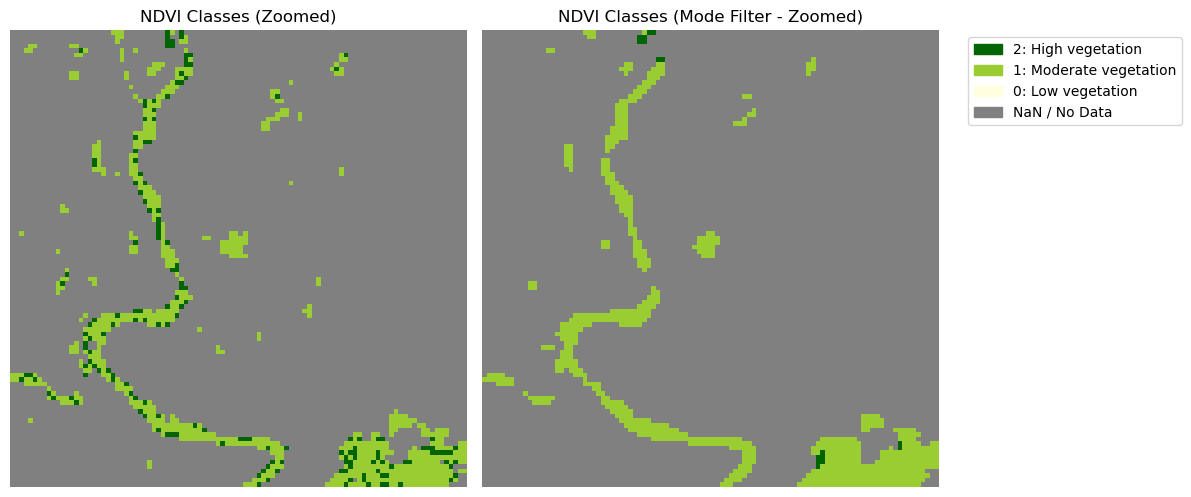

In [80]:
from matplotlib.colors import ListedColormap

# Crear un colormap personalizado que coincida con la leyenda
custom_cmap = ListedColormap(['lightyellow', 'yellowgreen', 'darkgreen', 'grey'])  # 0, 1, 2, NaN

# Asegurarse de que los valores NaN se muestren como gris
from matplotlib import cm
custom_cmap.set_bad(color='grey')

# Volver a graficar usando el nuevo colormap
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left: original NDVI classification
axs[0].imshow(ndvi_zoom, cmap=custom_cmap, vmin=-1, vmax=2)
axs[0].set_title("NDVI Classes (Zoomed)")
axs[0].axis("off")

# Right: smoothed version
axs[1].imshow(grain_zoom, cmap=custom_cmap, vmin=-1, vmax=2)
axs[1].set_title("NDVI Classes (Mode Filter - Zoomed)")
axs[1].axis("off")

# Same legend
axs[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
